## Transfer Learning Inception V3 using Keras

Please download the dataset from the below url

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS =25

In [ ]:
import tensorflow as tf

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML/3types Lungs Disease",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3986 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal']

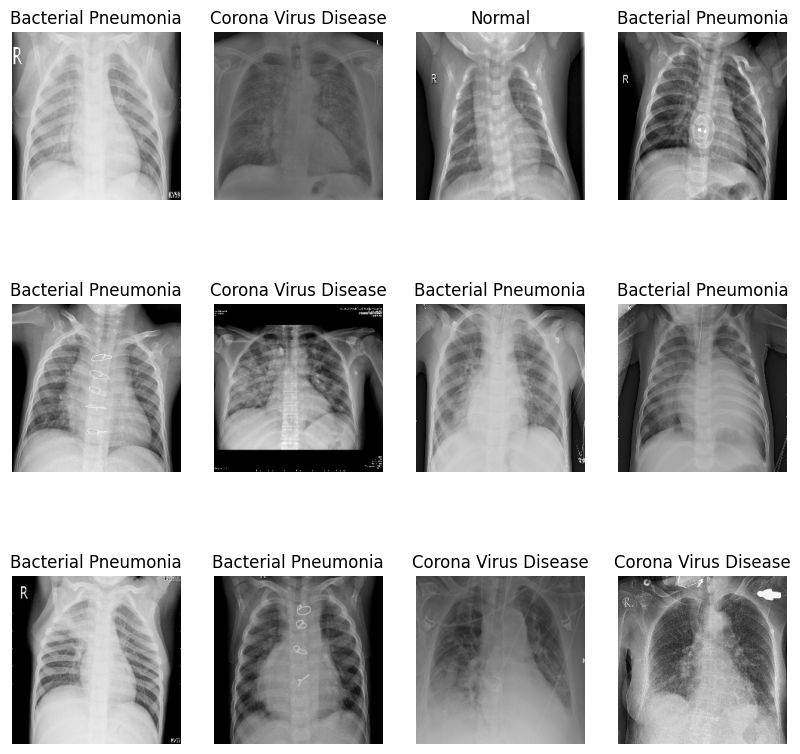

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


In [ ]:
len(dataset)

125

In [ ]:
train_size =0.8
len(dataset)*train_size

100.0

In [ ]:
train_ds = dataset.take(100)
len(train_ds)

100

In [ ]:
test_ds=dataset.skip(100) 
len(test_ds)

25

In [ ]:
val_size = 0.1
len(dataset)*val_size

12.5

In [ ]:
val_ds=test_ds.take(12)
len(val_ds)

12

In [ ]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1,test_split=0.1,shuffle =True,shuffle_size=10000):

  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds =ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

100

In [ ]:
len(val_ds)

12

In [ ]:
len(test_ds)

13

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
image_size=[224,224]

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/223)  
])


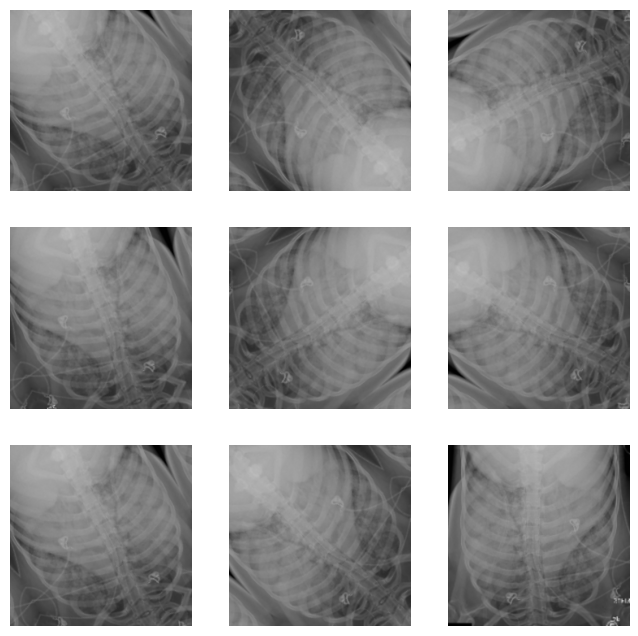

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(8,8))
for images, labels in test_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax=plt.subplot(3,3,i+1)

    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=image_size + [3], weights='imagenet', include_top=False)




In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/ML/3types Lungs Disease/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:

# view the structure of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/25


In [ ]:
scores1=model.evaluate(train_ds)

In [ ]:
scores2=model.evaluate(test_ds)

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  print(images_batch[0].numpy().astype('uint8'))

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%.")
    plt.axis("off")


In [ ]:
tf.__version__